In [4]:
MDtrajs_dir="./MDtrajs/"
Featurization_dir="./Featurization/"
FSelection_dir = "./FSel/"
GMRQ_dir="./GMRQ/"

### GMRQ Cross Validation of SRVNet

In [2]:
import os
import pickle
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import KMeans, KCenters, MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel
import multiprocessing
from joblib import Parallel, delayed
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import *

import sys
sys.path.insert(0, './scripts')
from VAMPNet_SRVNet import *

In [5]:
def load_pickles(file_dir):
    pickle_files = glob.glob(file_dir)
    data_list = []
    for file in pickle_files:
        with open(file, "rb") as f:
            data = pickle.load(f)
            data_list.append(data)
    return data_list

srvCV_dir = "./GMRQ/srv/"
if not os.path.exists(srvCV_dir):
        os.mkdir(srvCV_dir)

for para in ['lagtime', 'n_cvs', 'n_clusters']:
    para_dir = srvCV_dir + para + '/'
    if not os.path.exists(para_dir):
        os.mkdir(para_dir)

In [ ]:
oasis_trajs = np.load(FSelection_dir + "oasis_trajs.npy", allow_pickle=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

def SRV_CV(trajs, lt=200, n_cvs=3, n_clusters=200, para='lagtime',
           lr=1e-4, n_epochs=15, train_batchsize=50000,
           runs=10, n_fold=5, device=None):
    
    output_files_dir = srvCV_dir + para + '/'
    
    results = []
    for run in range(runs):
        cv = KFold(n_splits=n_fold, shuffle=True)
        for train_index, test_index in cv.split(trajs):
            network_lobe = nn.Sequential(
                nn.BatchNorm1d(400), 
                nn.Linear(400, 200), nn.ELU(), 
                nn.Linear(200, 100), nn.ELU(), 
                nn.Linear(100, 50), nn.ELU(), 
                nn.Linear(50, 20), nn.ELU(), 
                nn.Linear(20, 10), nn.ELU(), 
                nn.Linear(10, 5), nn.ELU(), 
                nn.Linear(5, n_cvs))
            network_lobe = network_lobe.to(device=device)
        
            projector = deep_projector(network_type='SRVNet', lobe=network_lobe,
                                       epsilon=1e-6, learning_rate=lr, device=device)
        
            
            train_data = [trajs[i] for i in train_index]
            test_data = [trajs[i] for i in test_index]
            
            past, future = TimeLaggedDataset(trajs=train_data, lagtime=lt, normalize=False)
            train_loader =  split_train_validate_data(pastdata=past, futuredata=future, 
                                                      validation_ratio=0, train_batchsize=train_batchsize)
            projector.fit(train_loader=train_loader, num_epochs=n_epochs)
            
            srv_traj_train = projector.transform(data=train_data)
            srv_traj_test = projector.transform(data=test_data)
            del projector
            
            # This tICA is not used for dimensionality reduction
            # but for orthogonalization
            tica = tICA(n_components=n_cvs, lag_time=lt, kinetic_mapping=False)
            tica.fit(srv_traj_train)
            ntrajs_train = tica.transform(srv_traj_train)
            ntrajs_test = tica.transform(srv_traj_test)
            del tica
            
            cluster = KCenters(n_clusters=n_clusters)
            cluster.fit(ntrajs_train)
            ctraj_train = cluster.predict(ntrajs_train)
            ctraj_test = cluster.predict(ntrajs_test)
            del cluster
            
            msm = MarkovStateModel(n_timescales=3, lag_time=500, reversible_type='transpose', 
                                   verbose=False, ergodic_cutoff='off')
            msm.fit(ctraj_train)
            train_score = msm.score(ctraj_train)
            test_score = msm.score(ctraj_test)
            
            results.append({
                'type': 'train', 'score': train_score, 
                'lagtime': lt, 'n_cvs': n_cvs, 'n_clusters': n_clusters})
            results.append({
                'type': 'test', 'score': test_score, 
                'lagtime': lt, 'n_cvs': n_cvs, 'n_clusters': n_clusters})
            gc.collect()
            torch.cuda.empty_cache()
        print('Run {} for {}lt, {}cvs, {}clusters is complete'.format(run,lt,n_cvs,n_clusters))
    frame = pd.DataFrame(results)
    frame.to_pickle(output_files_dir + "{}lt_{}cvs_{}clusters_gmrq.pickl".format(lt,n_cvs,n_clusters))

In [ ]:
lt_list = [50, 100, 200, 300, 400, 500]
Parallel(n_jobs=3)(delayed(SRV_CV)(trajs=oasis_trajs, 
                                   lt=i, n_cvs=3, n_clusters=200, 
                                   para='lagtime') for i in lt_list)

In [ ]:
ncvs_list = [2, 3, 4, 5]
Parallel(n_jobs=4)(delayed(SRV_CV)(trajs=oasis_trajs, 
                                   lt=200, n_cvs=i, n_clusters=200, 
                                   para='n_cvs') for i in ncvs_list)

In [ ]:
nc_list = [50, 100, 200, 300, 400, 500]
Parallel(n_jobs=3)(delayed(SRV_CV)(trajs=oasis_trajs, 
                                   lt=200, n_cvs=3, n_clusters=i, 
                                   para='n_clusters') for i in nc_list)

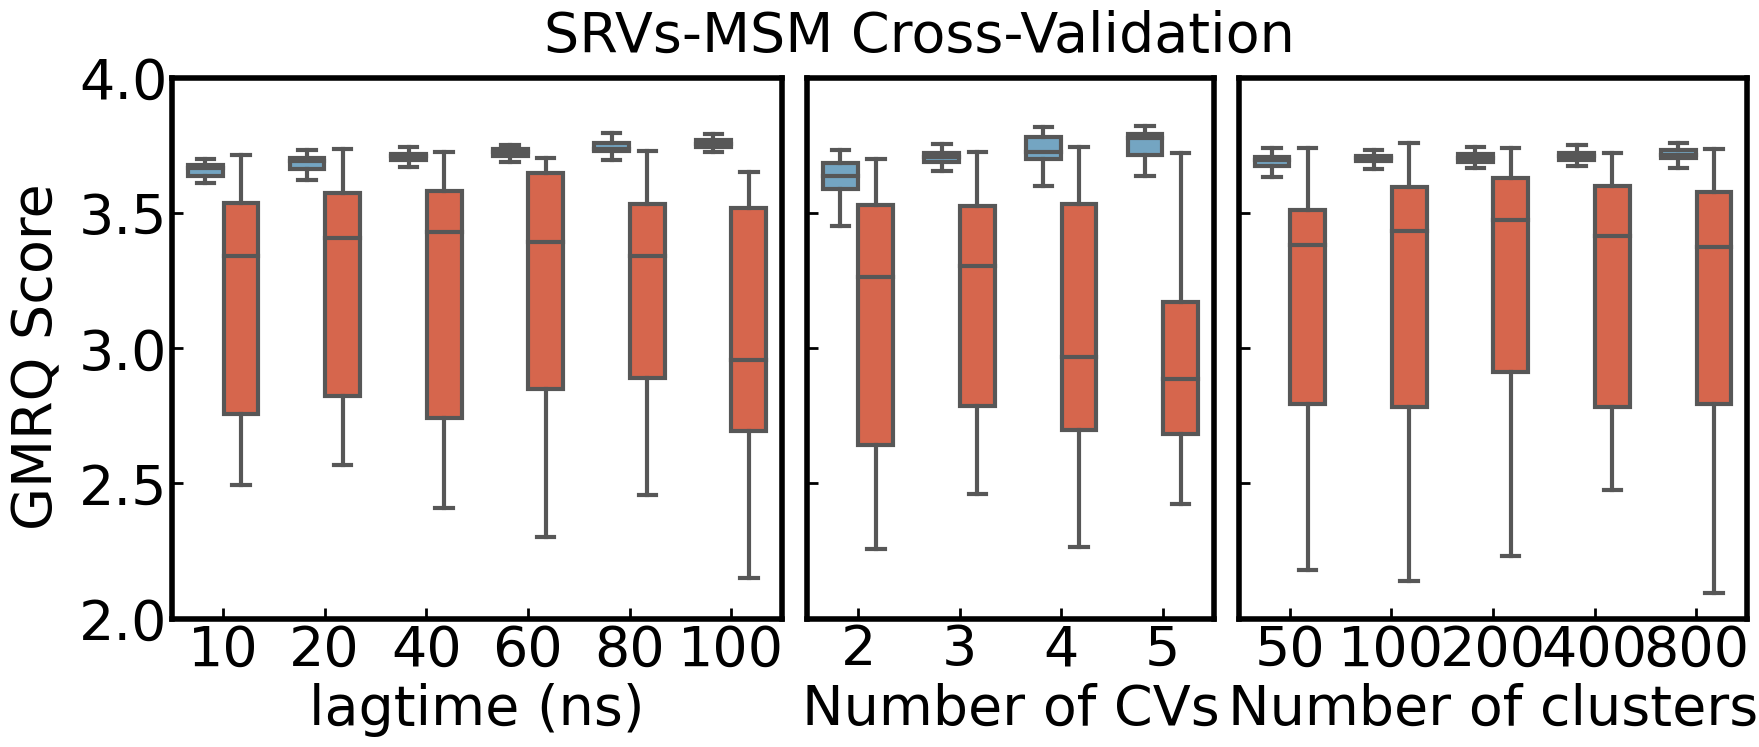

In [6]:
plt.rcParams['font.size'] = 40
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True,
                         gridspec_kw={'width_ratios': [6,4,5]})
axes = axes.ravel()
pal = {'train': '#67a9cf', 'test': '#ed5736'}

para = ['lagtime', 'n_cvs', 'n_clusters']
for i in range(len(para)):
    file_dir = srvCV_dir + para[i] + '/'
    data = load_pickles(file_dir + '*.pickl')
    df = pd.concat(data, axis=0)
    df['lagtime'] = np.int16(df['lagtime'] * 0.2)
    sns.boxplot(data=df, x=para[i], y='score', hue='type', 
                orient="v", notch=False, 
                palette=pal, linewidth=3, width=0.7, 
                sym=".", showfliers=False, ax=axes[i])
    axes[i].set_ylabel("")   
    axes[i].set_ylim(2, 4)
    axes[i].legend([], frameon=False)
    axes[i].tick_params(axis='both', direction='in', width=2, length=8)
    for spine in axes[i].spines.values():
        spine.set_linewidth(4)

axes[0].set_xlabel("lagtime (ns)")
axes[1].set_xlabel("Number of CVs")
axes[2].set_xlabel("Number of clusters")
fig.text(0.01, 0.55, "GMRQ Score", ha='center', va='center', rotation=90)
fig.text(0.5, 0.95, "SRVs-MSM Cross-Validation", ha='center', va='center')
# axes[2].legend(loc='center', bbox_to_anchor=(-0.5, 1.1), ncol=2)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.savefig('./png/gmrq_srv.png', dpi=500, bbox_inches='tight')

plt.show()